In [1]:
# Import libraries that we'll need...
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.utils import resample
import matplotlib
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from statsmodels.nonparametric.smoothers_lowess import lowess

In [2]:
# Import data (I uploaded a copy to blackboard) and see what's in it
df_func_renal = pd.read_excel('liver_data.xlsx')
df_func_renal.head()

,age,comp_liver_ind
0,18,2.44
1,19,3.86
2,19,-1.22
3,20,2.30
4,21,0.98


In [3]:
# As usual, plot the data...
df_func_renal.plot(x='age', y='comp_liver_ind', kind='scatter', figsize=(20,10))

In [4]:
# Fit an Ordinary Least Squares (OLS) Regression estimator
ols_reg_model = OLS(df_func_renal['comp_liver_ind'], add_constant(df_func_renal['age'])).fit()
ols_reg_model.summary()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         comp_liver_ind   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     75.31
Date:                Fri, 16 Aug 2019   Prob (F-statistic):           5.18e-15
Time:                        08:05:52   Log-Likelihood:                -314.14
No. Observations:                 157   AIC:                             632.3
Df Residuals:                     155   BIC:                             638.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8600      0.360      7.954      0.000       2.150       3.570
age           -0.0786      0.009     -8.678      0.000      -0.096      -0.061
==============================================================================
Omnibus:                        1.091   Durbin-Watson:                   2.254
Prob(Omnibus):                  0.580   Jarque-Bera (JB):                1.147
Skew:                           0.194   Prob(JB):                        0.564
Kurtosis:                       2.843   Cond. No.                         99.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [5]:
# Fill a new dataframe column with the OLS predictions
df_func_renal['OLS_fit'] =  ols_reg_model.predict()

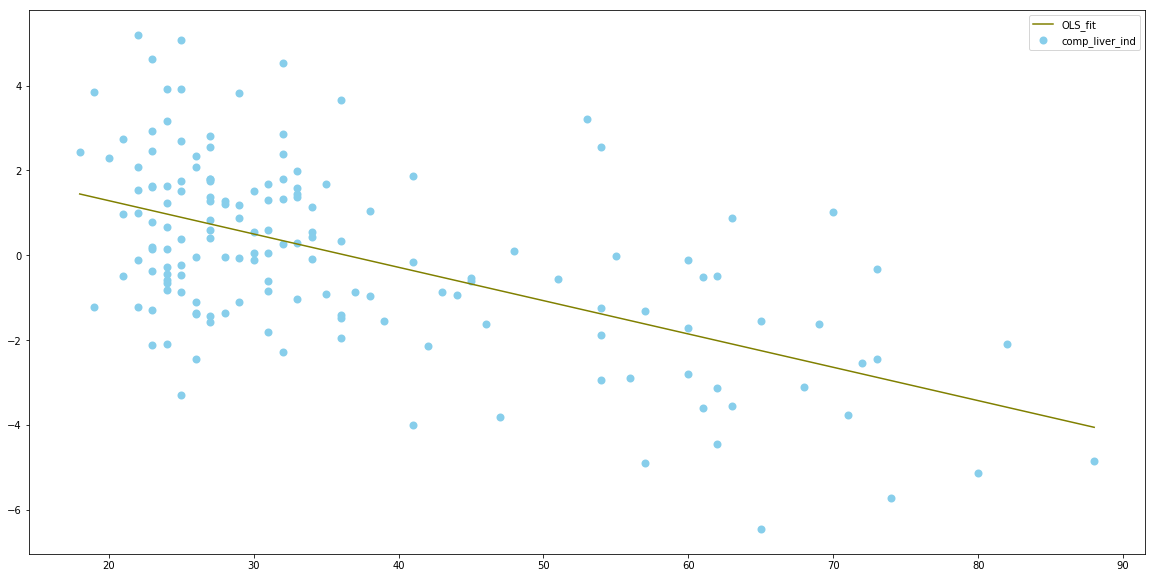

In [6]:
# Plot OLS predictions in same graph as linear model prediction
plt = matplotlib.pyplot
plt.figure(figsize=(20,10))
plt.scatter(df_func_renal['age'], df_func_renal['comp_liver_ind'],
         marker='o', color='skyblue', linewidth=2)
plt.plot(df_func_renal['age'], df_func_renal['OLS_fit'], color='olive')
plt.legend()
plt.show()

### Now, we will compute the inference of our OLS estimates
<font size="3"> First, we will compute the **standard deviation of the residuals** </font> $\large{\hat{\sigma}_\epsilon = \Bigg[\frac{\sum{(y_i - \hat{y_i})^2}}{(N-2)}}\Bigg]^\frac{1}{2} = \large{\Bigg[\frac{\sum{\varepsilon_i^2}}{(N-2)}\Bigg]^\frac{1}{2}}$. 
<br>
<font size="3"> Recall that degrees of freedom (dof) </font> $\nu = N- 2$ <font size="3"> since we estimated 2 parameters from the data) </font>.
<br>
<font size="3"> Then, the **standard error of the forecasted value** $\hat{y}_i$ ,  </font> $\large{\hat{\sigma}_\hat{y_i} =  \hat{\sigma}_\epsilon \Bigg[\frac{1}{N} + \frac{(x_i - \bar{x})^2}{\sum{(x_i - \bar{x})^2}}\Bigg]^\frac{1}{2}}$
<br>
<font size="3"> Finally, we'll get a 2-standard prediction error (~95% two-tailed) confidence interval around each </font> $\large{\hat{y}_i}$

In [7]:
# Carrying out the calculations described above
df_func_renal['OLS_residuals'] = df_func_renal['comp_liver_ind'] - df_func_renal['OLS_fit']
N = df_func_renal['comp_liver_ind'].shape[0]
dof = N - 2
sigma_hat_epsilon = np.sqrt((df_func_renal['OLS_residuals'] ** 2).sum() / dof)
df_func_renal['forecast_se'] = sigma_hat_epsilon * (1/N + ((df_func_renal['age'] - df_func_renal['age'].mean()) ** 2 ) / (((df_func_renal['age'] - df_func_renal['age'].mean()) ** 2).sum())) ** (1/2)
df_func_renal['low_OLS_fit'] = df_func_renal['OLS_fit'] - 1.64 * df_func_renal['forecast_se']
df_func_renal['high_OLS_fit'] = df_func_renal['OLS_fit'] + 1.64 * df_func_renal['forecast_se']

In [8]:
df_func_renal.loc[df_func_renal['age'].isin([20,30,41,51,60,70,80]),['age', 'forecast_se']].drop_duplicates()

,age,forecast_se
3,20,0.206648
74,30,0.154965
113,41,0.149665
124,51,0.195329
134,60,0.257595
148,70,0.336559
154,80,0.420226


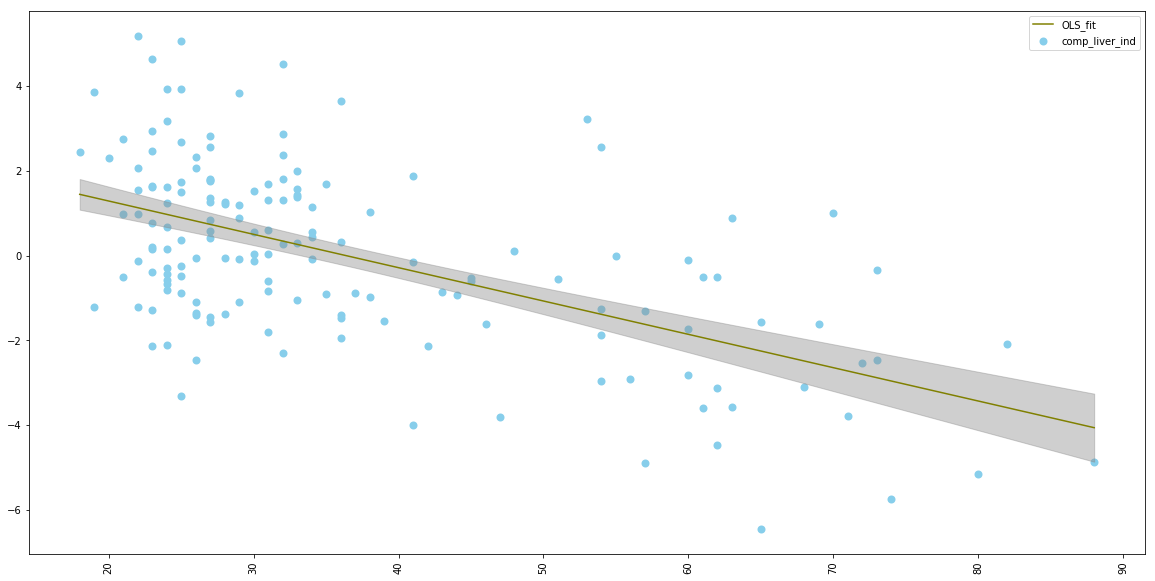

In [9]:
# Plotting forecast confidence intervals
plt = matplotlib.pyplot
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
plt.scatter(df_func_renal['age'], df_func_renal['comp_liver_ind'],
         marker='o', color='skyblue', linewidth=2)
plt.plot(df_func_renal['age'], df_func_renal['OLS_fit'], color='olive')
plt.fill_between(df_func_renal['age'], df_func_renal['low_OLS_fit'], df_func_renal['high_OLS_fit'], color='#888888', alpha=0.4)

plt.legend()
plt.show()

In [10]:
# Computing Lowess fit
df_func_renal['lowess_fit'] = lowess(df_func_renal['comp_liver_ind'], df_func_renal['age'], return_sorted=False, frac=1/3) \
                                 .reshape(df_func_renal['comp_liver_ind'].shape[0],)

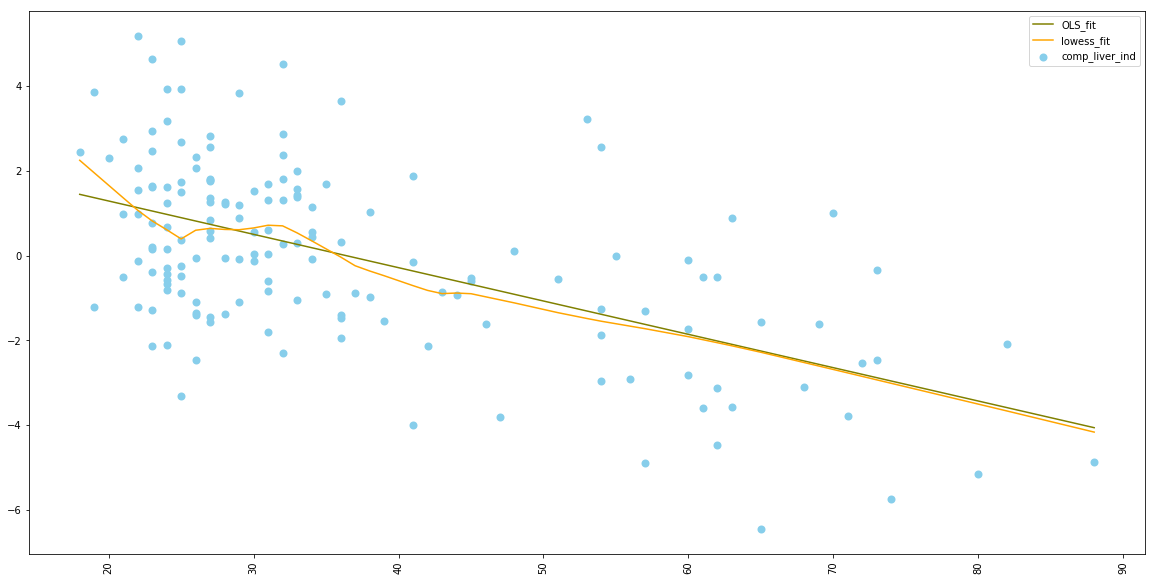

In [11]:
# Plotting Lowess predicions vs. data and vs. OLS predictions
plt = matplotlib.pyplot
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
plt.scatter(df_func_renal['age'], df_func_renal['comp_liver_ind'],
         marker='o', color='skyblue', linewidth=2)
plt.plot(df_func_renal['age'], df_func_renal['OLS_fit'], color='olive')
plt.plot(df_func_renal['age'], df_func_renal['lowess_fit'], color='orange')
plt.legend()
plt.show()

In [12]:
# Perform bootstrap ressampling and collect results.
N = df_func_renal['age'].shape[0]
B = 250
for bootstrap_it in range(1, B+1):
    resampled_df = resample(df_func_renal[['age', 'comp_liver_ind']], n_samples=N)
    resampled_df['lowess_fit_B' + str(bootstrap_it)] = lowess(resampled_df['comp_liver_ind'], resampled_df['age'], return_sorted=False, frac=1/3) \
                                 .reshape(resampled_df['comp_liver_ind'].shape[0],)
    resampled_df = resampled_df.groupby('age')['lowess_fit_B' + str(bootstrap_it)].mean().reset_index()
    df_func_renal = df_func_renal.merge(resampled_df[['age', 'lowess_fit_B' + str(bootstrap_it)]], on='age', how='left')

In [14]:
# Get bootstrap quantiles from bootstrap estimates
bootstrap_cols = [col for col in df_func_renal.columns if 'fit_B' in col]
df_func_renal['se_b'] = df_func_renal[bootstrap_cols].std(axis=1)
df_func_renal.loc[df_func_renal['age'].isin([20,30,41,51,60,70,80]), ['age', 'se_b']].drop_duplicates()

,age,se_b
3,20,0.527420
74,30,0.241969
113,41,0.308763
124,51,0.291588
134,60,0.367537
148,70,0.519985
154,80,0.576001


In [14]:
bootstrap_quantiles = df_func_renal[bootstrap_cols].quantile(np.linspace(.05,.95, 10), axis=1).transpose()
b_quants = ['B_quant_05', 'B_quant_15', 'B_quant_25','B_quant_35','B_quant_45',
                               'B_quant_55','B_quant_65', 'B_quant_75','B_quant85','B_quant_95']
bootstrap_quantiles.columns = b_quants
df_func_renal = pd.concat([df_func_renal[['age', 'comp_liver_ind', 'lowess_fit', 'OLS_fit', 'low_OLS_fit', 'high_OLS_fit']], bootstrap_quantiles], sort=False, axis=1)

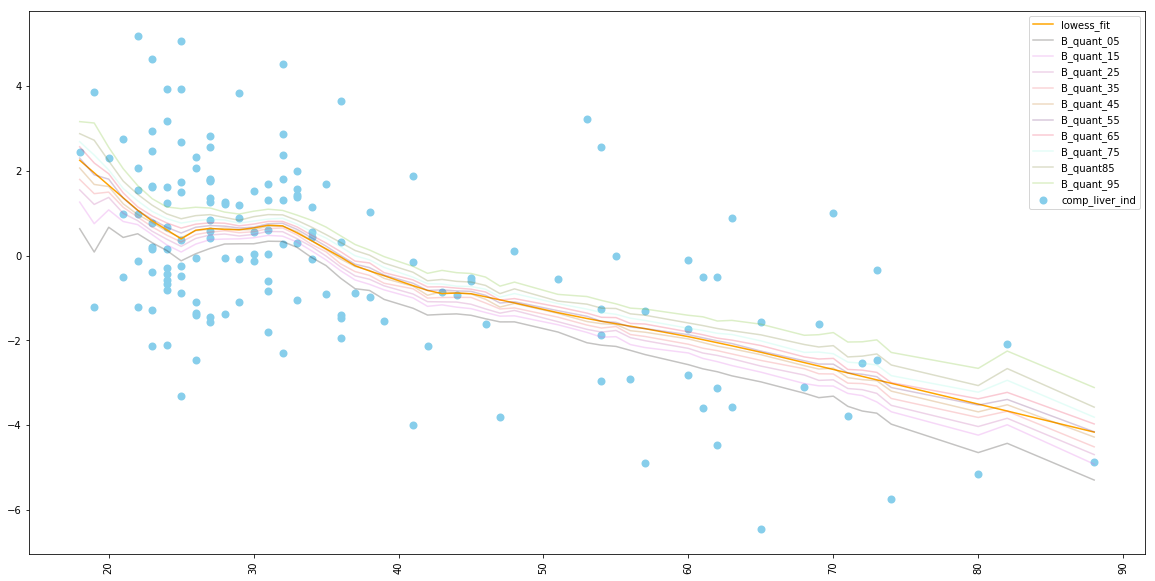

In [15]:
# Plotting Lowess predicions vs. data vs. Bootstrap quantiles
plt = matplotlib.pyplot
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
plt.scatter(df_func_renal['age'], df_func_renal['comp_liver_ind'],
         marker='o', color='skyblue', linewidth=2)
plt.plot(df_func_renal['age'], df_func_renal['lowess_fit'], color='orange')
for bootstrap_quant in b_quants:
    plt.plot(df_func_renal['age'], df_func_renal[bootstrap_quant], color=np.random.rand(3,), alpha=0.25)
plt.legend()
plt.show()

In [16]:
# Compute the width of 90% conficence intervals
df_func_renal['OLS_conf_width'] = df_func_renal['high_OLS_fit'] - df_func_renal['low_OLS_fit']
df_func_renal['lowess_conf_width'] = df_func_renal['B_quant_95'] - df_func_renal['B_quant_05']

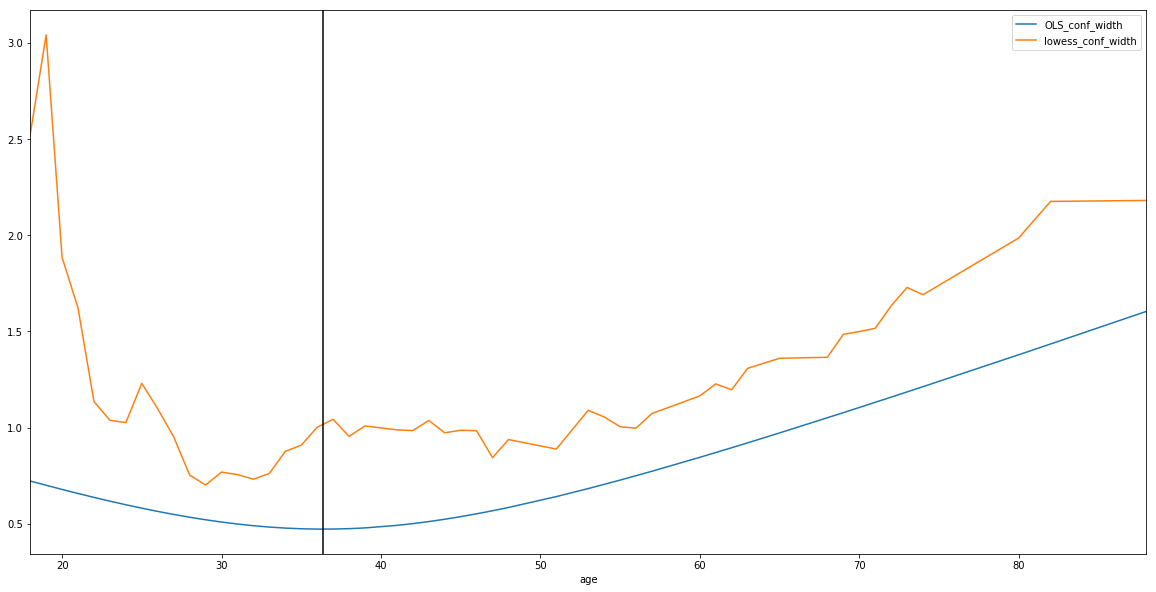

In [17]:
# Plot the confidence interval widths vs. age. We can see that the OLS confidence int is narrowest at the mean of x.
ax = df_func_renal[['age', 'OLS_conf_width', 'lowess_conf_width']].plot(figsize=(20,10), x='age', y=['OLS_conf_width', 'lowess_conf_width'])
ax.axvline(x=df_func_renal['age'].mean(), color='black')